In [1]:
import numpy as np
import pandas as pd
from sympy import isprime
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import threading
from itertools import permutations

In [2]:
cities = pd.read_csv('../input/cities.csv')
cities_len = len(cities)
print("len: ", cities_len)
cities_xy = np.stack((cities.X.values, cities.Y.values), axis=1)
cities_xy[0:5]

len:  197769


array([[ 316.83673906, 2202.34070734],
       [4377.40597217,  336.60208217],
       [3454.15819771, 2820.05301125],
       [4688.09929763, 2935.89805581],
       [1010.69695175, 3236.75098903]])

In [23]:
def get_score(path):
    xy = cities_xy[path]
    values = np.linalg.norm(xy-np.roll(xy, -1, axis=0), axis=1)[:-1]
    prime_value = (values[9::10] * [int(isprime(i)==False)*0.1 for i in path[:-1][9::10]]).sum()
    return values.sum() + prime_value

def get_dist_values(path:np.ndarray):
    xy = cities_xy[path]
    values = np.linalg.norm(xy-np.roll(xy, -1, axis=0), axis=1)[:-1]
    values[9::10] += values[9::10] * [int(isprime(i)==False)*0.1 for i in path[:-1][9::10]]
    return values

def get_score_not_prime(path):
    xy = cities_xy[path]
    values = np.linalg.norm(xy-np.roll(xy, -1, axis=0), axis=1)[:-1]
    return values.sum()

In [4]:
#path = pd.read_csv('../input/submission_20181210.csv')
path = pd.read_csv('../input/sample_submission.csv')
path = path['Path'].values
get_score(path)

446884407.5212081

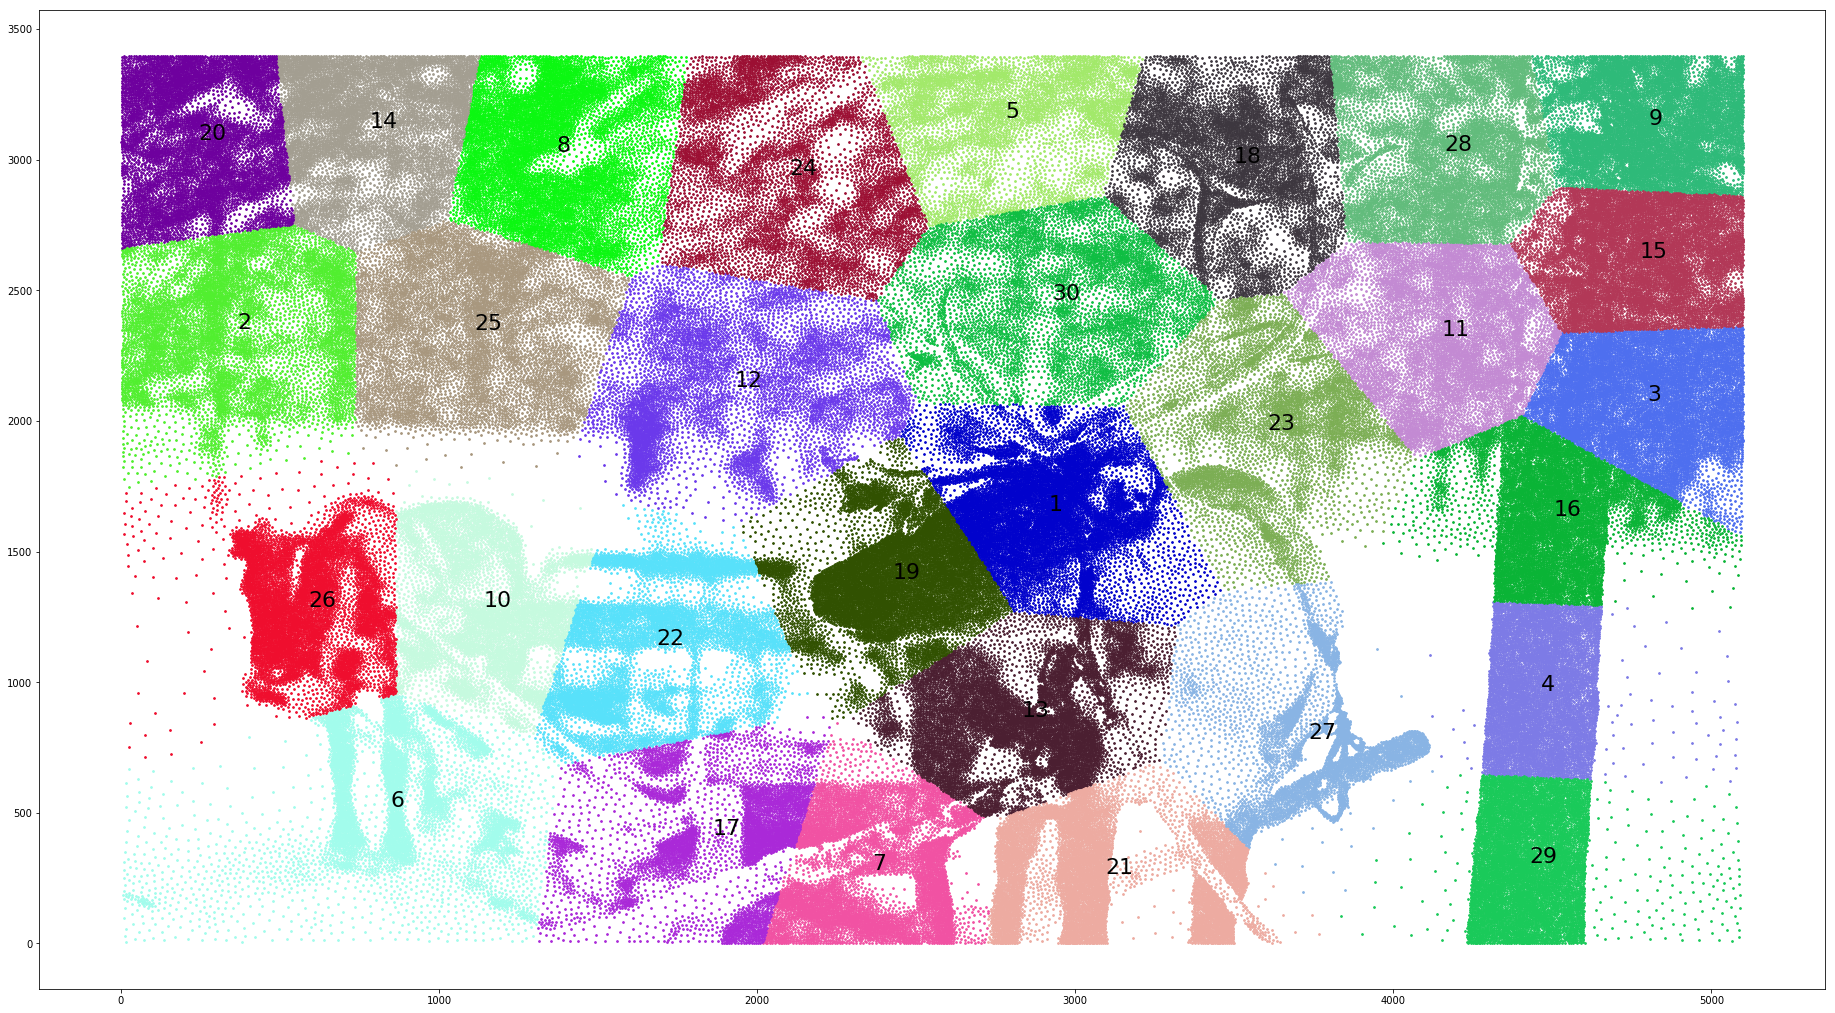

In [6]:
from sklearn.cluster import KMeans

n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters).fit(cities[['X', 'Y']])
kmeans.labels_

fig, ax = plt.subplots(figsize=(32,18))
plt.rcParams.update({'font.size': 22})
for i in range(n_clusters):
    c = [np.random.random_sample(), np.random.random_sample(), np.random.random_sample()]
    points = cities[kmeans.labels_==i]
    mean = points.mean()
    
    plt.scatter(points.X, points.Y, color=c, s=3)
    ax.annotate(str(i+1), (mean.X, mean.Y))    

In [5]:
gap_x = cities_xy[:,0].max() - cities_xy[:,0].min()
gap_y = cities_xy[:,1].max() - cities_xy[:,1].min()

def get_near_list(p:np.ndarray, pn:int)->np.ndarray:
    p_xy = cities_xy[p]
    pn_xy = cities_xy[pn] 
    r = np.sqrt(p.size/2)
    gap_xr = gap_x/r+1
    gap_yr = gap_y/r+1
    gap_p = 1
    while True:
        gap_x_value = gap_xr*gap_p
        gap_y_value = gap_yr*gap_p
        list_test = np.where((p_xy[:,0] >pn_xy[0]-gap_x_value) & 
                             (p_xy[:,0] <pn_xy[0]+gap_x_value) &
                             (p_xy[:,1] >pn_xy[1]-gap_y_value) & 
                             (p_xy[:,1] <pn_xy[1]+gap_y_value))
        if len(list_test[0]) == 0:
            gap_p += 1
        else:
            break
    return list_test[0]

def get_nearest_index(p:np.ndarray, pn:int)->np.int:
    p_xy = cities_xy[p]
    pn_xy = cities_xy[pn] 
    return np.linalg.norm(p_xy-pn_xy, axis=1).argmin()

def get_nears_index(p:np.ndarray, pn:int, size:int=1)->np.int:
    p_xy = cities_xy[p]
    pn_xy = cities_xy[pn] 
    return np.argsort(np.linalg.norm(p_xy-pn_xy, axis=1))[:size]

def sort_path_index(path:np.ndarray)->np.ndarray:
    xy = cities_xy[path]
    dists = np.linalg.norm(xy-cities_xy[0], axis=1)
    return np.argsort(dists)

def sort_path(path:np.ndarray)->np.ndarray:
    list_ntp = sort_path_index(path)
    return path[list_ntp]

#path_test = np.array([0,1,2,3,4,5,0])
#type(get_nearest_index(path_test, 8))

In [34]:
def put_city_near(p:np.ndarray, pn:int)->np.ndarray:
    list_test = get_near_list(p, pn)
        
    best_k = None
    min_dist = 999999999
    for k in list_test:
        if k == 0: 
            continue

        betw = p[k-1:k+1]
        dist = get_score_not_prime(betw)
        pnn = np.insert(betw, 1, pn)
        dist_test = get_score_not_prime(pnn)
        if dist_test - dist < min_dist:
            min_dist = dist_test-dist
            best_k = k
    return np.insert(p, best_k, pn)

def put_cities_same_things()->np.ndarray:
    path = np.arange(cities_len)
    #path = np.append(np.arange(1000), [0])
    p = np.array([0,0])
    pr = path[1:]
    while pr.size != 0:
        c_index = np.random.choice(p.size)
        list_near_index = get_near_list(pr, p[c_index])
        #pr = pr[np.isin(pr, list_near) == False]
        list_near = sort_path(pr[list_near_index])
        pr = np.delete(pr, list_near_index)
        
        for pn in list_near:
            p = put_city_near(p, pn)
            
        print ('city count: {}'.format(p.size), end="\r")
    return p

best_path = put_cities_same_things()
print(get_score(best_path), best_path)

38162.33416201827 [ 0 99 87 62  5 76 60 48 88 38 36 41 40 20  9 43 75 90 72 31 49 97 95 51
 69 58 21 47 15 92 68 44 37 53 70 79 78 96 26 59 94  1 63 57 24  7 35 19
 42 81 45 30 11 82 13 29 14 64 10 73 46 80 55 34  4 22 93 52  6  8 67 28
 66  2 23 85 89 27 54 17 84 25  3 77 33 56 74 50 16 32 98 65 83 91 71 12
 18 39 61 86  0]


In [27]:
def put_city_nearest(p:np.ndarray, pn:int)->np.ndarray:
    nearest_test_index = get_nearest_index(p, pn)
    
    best_k = None
    min_dist = 999999999
    list_test = np.array([nearest_test_index, nearest_test_index+1])
    for k in list_test:
        if k < 1: 
            continue
        betw = p[k-1:k+1]
        dist = get_score_not_prime(betw)
        #print(p, k, betw, pn)
        pnn = np.insert(betw, 1, pn)
        dist_test = get_score_not_prime(pnn)
        if dist_test - dist < min_dist:
            min_dist = dist_test-dist
            best_k = k
    return np.insert(p, best_k, pn)

def put_cities_nearest()->np.ndarray:
    path = np.arange(cities_len)
    p = np.array([0,0])
    pr = path[1:]
    while pr.size != 0:
        c_index = np.random.choice(p.size)
        nearest_index = get_nearest_index(pr, p[c_index])
        pn = pr[nearest_index]
        pr = np.delete(pr, nearest_index)
        p = put_city_nearest(p, pn)
            
        print ('city count: {}'.format(p.size), end="\r")
    return p

best_path = put_cities_nearest()
print(get_score(best_path), best_path)

39501.78490913728 [ 0 99 82 13 29 14 64 10 73 46 80 55 34  4 22 93 67 28 66  2 85 27 54 17
 84 56 33 77  3 25 74 50 16 32 98 65 83 89 23 91 71 12 48 88 60 18 52  6
  8 39 38 36 41 40 20  9 43 72 97 49 31 90 75 47 58 51 95 69 21 15 96 26
 59  1 94 63 57 24 78 92 68 44 76  5 62 70 53 37 19  7 35 42 81 45 30 11
 79 87 61 86  0]


In [7]:
cities_len = 100
def put_cities_nearest2()->np.ndarray:
    path = np.arange(cities_len)
    p = np.array([0,0])
    pr = path[1:]
    prs = sort_path(pr)
    
    for pn in prs:
        p = put_city_nearest(p, pn)
        print ('city count: {}'.format(p.size), end="\r")
    return p

best_path = put_cities_nearest2()
print(get_score(best_path), best_path)

40184.82329198653 [ 0 99 87 62  5 60 48 88 38 36 41 76 68 40 20  9 43 72 97 49 31 90 75 47
 58 51 95 69 21 15 96 26 59  1 94 63 57 24 78 92 44 37 53 70 79 11 19  7
 35 42 81 45 30 82 13 29 14 64 10 73 46 80 55 34  4 22 93 52  6  8 67 28
 66  2 85 27 54 17 84 25  3 77 33 56 74 50 16 32 98 65 83 89 23 91 71 12
 18 39 61 86  0]


In [32]:
def put_city_nears(p:np.ndarray, pn:int, near_size:int=2)->np.ndarray:
    list_test_index = get_nears_index(p, pn, near_size)
    list_test = np.unique(np.append(list_test_index, list_test_index+1))
    #print(list_test_index, list_test)
    
    best_k = None
    min_dist = 999999999
    for k in list_test:
        if k < 1: 
            continue
        betw = p[k-1:k+1]
        dist = get_score_not_prime(betw)
        #print(p, k, betw, pn)
        pnn = np.insert(betw, 1, pn)
        dist_test = get_score_not_prime(pnn)
        if dist_test - dist < min_dist:
            min_dist = dist_test-dist
            best_k = k
    return np.insert(p, best_k, pn)

def put_cities_nears()->np.ndarray:
    path = np.arange(cities_len)
    p = np.array([0,0])
    pr = path[1:]
    prs = sort_path(pr)
    
    for pn in prs:
        p = put_city_nears(p, pn, 7)
        print ('city count: {}'.format(p.size), end="\r")
    return p

cities_len = 100
best_path = put_cities_nears()
print(get_score(best_path), best_path)

34615.38201887454 [ 0  0 86 61 39 18 12 71 91 23 89 83 65 98 32 16 50 74 56 33 77  3 25 84
 17 54 27 85  2 66 28 67  8  6 52 93 22  4 34 55 80 46 73 10 14 64 29 99
 13 82 87 79 62  5 68 92 41 40 15 20 47 21 58 69 51 95 97 49 31 72 90 75
 43  9 88 48 60 38 36 76 44 70 53 37 11 30 45 81 42 19 78 96 26 59 94  1
 63 57 24  7 35]


In [59]:
def change_city_nears(path:np.ndarray, pi:int, near_size:int=2)->np.ndarray:
    p = np.copy(path)
    list_test_index = get_nears_index(p, p[pi], near_size+1)
    
    k_best = None
    pi_dist = get_score_not_prime(p[pi-1:pi+2])
    min_dist = 0
    for k in list_test_index:
        if k < 1 or k > p.size-2 or k == pi: 
            continue
        
        k_dist = get_score_not_prime(p[k-1:k+2])
        p[pi], p[k] = p[k], p[pi]
        
        cpi_dist = get_score_not_prime(p[pi-1:pi+2])    
        ck_dist = get_score_not_prime(p[k-1:k+2])  
        
        p[pi], p[k] = p[k], p[pi]
        if  cpi_dist + ck_dist - pi_dist - k_dist < min_dist:
            min_dist = cpi_dist + ck_dist - pi_dist - k_dist
            k_best = k
    
    if k_best is not None:
        p[pi], p[k_best] = p[k_best], p[pi]
    return p

def change_near_paths(path:np.ndarray):
    for i, pn in np.ndenumerate(path[1:-1]):
        pi = i[0]+1
        path = change_city_nears(path, pi, 10)
    return path
        #break

print(get_score_not_prime(best_path), best_path)        
best_path = change_near_paths(best_path)
print(get_score_not_prime(best_path), best_path)

35474.75903625401 [ 0 87 79 62  5 76 36 38 60 88 48  9 75 43 90 72 31 49 97 95 69 51 58 21
 47 20 15 40 92 68 41 44 70 53 37 78 96 59 26 94 63  1 57 24  7 35 42 19
 81 45 30 11 82 13 99 29 64 14 10 73 46 80 55 52  6  8 34  4 22 93 67 28
 66  2 23 85 89 27 54 17 83 65 84 25  3 77 33 56 74 50 16 32 98 91 71 12
 18 39 61 86  0]
35474.75903625401 [ 0 87 79 62  5 76 36 38 60 88 48  9 75 43 90 72 31 49 97 95 69 51 58 21
 47 20 15 40 92 68 41 44 70 53 37 78 96 59 26 94 63  1 57 24  7 35 42 19
 81 45 30 11 82 13 99 29 64 14 10 73 46 80 55 52  6  8 34  4 22 93 67 28
 66  2 23 85 89 27 54 17 83 65 84 25  3 77 33 56 74 50 16 32 98 91 71 12
 18 39 61 86  0]


In [22]:
#print(best_path[0:3], cities_xy[best_path[0:3]])
xy = cities_xy[best_path[:2]]
get_score_not_prime(best_path[0:3])

print(np.roll(xy, -1, axis=0))

np.linalg.norm(xy-np.roll(xy, -1, axis=0), axis=1)

[[1372.65479479 1172.86937013]
 [ 316.83673906 2202.34070734]]


array([1474.63995637, 1474.63995637])

In [221]:
np.unique(best_path).size
path[0:1]

array([0])

In [120]:
a = np.array([1,2])
b = np.array([3,4])
c = np.array([5,6])
d = np.concatenate((a, b, [3]))
d[0:2]

array([1, 2])

In [77]:
def fix_path_far_dists(path):
    p = np.copy(path)
    
    before_dist_max = 99999999
    while True:
        xy = cities_xy[p]
        dists = np.linalg.norm(xy-np.roll(xy, -1, axis=0), axis=1)
        #print(dists)
        dist_max = dists.max()
        dist_mean = dists.mean()
        if dist_max >= before_dist_max:
            break
        
        fars_index = np.argwhere(dists > dist_mean)
        for n in fars_index:
            i = n[0]
            pn = p[i]
            if (pn == 0):
                continue
            pt = np.delete(p, i)
            p = put_city_nears(pt, pn, 10)
        before_dist_max = dist_max
    return p  

print(get_score_not_prime(best_path), best_path)
best_path = fix_path_far_dists(best_path)
print(get_score_not_prime(best_path), best_path)

34948.53620480023 [ 0 87 79 62  5 76 36 38 60 88 48  9 75 43 31 49 97 72 90 95 69 51 58 21
 47 20 15 40 92 68 41 44 70 53 37 78 24 96 59 26 94 63  1 57  7 35 42 19
 81 45 30 11 82 13 99 29 64 14 10 73 55 80 46 34 52  6  8  4 22 93 67 28
 66  2 23 85 89 83 27 54 17 65 84 25  3 77 33 56 74 50 16 32 98 91 71 12
 18 39 61 86  0]
34948.53620480023 [ 0 87 79 62  5 76 36 38 60 88 48  9 75 43 31 49 97 72 90 95 69 51 58 21
 47 20 15 40 92 68 41 44 70 53 37 78 24 96 59 26 94 63  1 57  7 35 42 19
 81 45 30 11 82 13 99 29 64 14 10 73 55 80 46 34 52  6  8  4 22 93 67 28
 66  2 23 85 89 83 27 54 17 65 84 25  3 77 33 56 74 50 16 32 98 91 71 12
 18 39 61 86  0]


In [61]:
def fix_path_small_permutation(seq_len:int=6, band_len:int=1, start_index:int=None):
    if band_len is None:
        band_len = np.random.choice(int((cities_len-1)/seq_len)) + 1
    small_len = band_len*seq_len
    if start_index is None:
        start_index = np.random.choice(cities_len - 1 - small_len)+1
    remainder = start_index%10
    if remainder == 0:
        score_start_index = start_index - 10
    else:
        score_start_index = start_index - remainder
    end_index = start_index + small_len
    if path.size < end_index + 2:
        end_index = path.size - 1
        start_index = end_index - small_len
    small = path[start_index : end_index]
    small_start = path[score_start_index:start_index]
    small_end = path[end_index:end_index+1]
    
    small_score = path[score_start_index: end_index+1]
    score = get_score(small_score)
    if band_len > 1:
        small = small.reshape((-1,band_len))
    for item in permutations(small):
        if band_len > 1:
            item = np.concatenate(item)
        small_path_test = np.concatenate((small_start, item, small_end))
        score_test = get_score(small_path_test)
        if score_test < score:
            path[start_index : start_index + small_len] = item
            #print("path updated, score : ", get_score(path), end="\r")
            score = score_test


def fix_path_use_thread(band_len:int=None, first_index:int=None, seq_len:int=6):
    if band_len is None:
        band_len = np.random.choice(int((cities_len-1)/seq_len)) + 1
    small_len = band_len * seq_len
    if first_index is None:
        first_index = np.random.choice(small_len)
    print('band_len:', band_len, ", first_index:", first_index)    
    threads_len = int((cities_len-1)/small_len)
    threads = []
    for i in range(threads_len+2):
        if i == 0:
            start_index = 1    
        else :
            start_index = first_index + (small_len * (i-1)) + 1
        
        if start_index > cities_len:
            break
        elif start_index + small_len + 1 > cities_len:
            start_index = first_index + cities_len-small_len-1
        t = threading.Thread(target=fix_path_small_permutation, args=(seq_len, band_len, start_index))
        threads.append(t)
    for t in threads:
        t.start()
    for t in threads:
        t.join()
        
path = best_path
print("start score : ", get_score(path))
no = 1
for i in [0,3,0,3]:
    fix_path_use_thread(1, i, 6)
    print("step:", no, " score: ", get_score(path))
    no += 1
print("final score : ", get_score(path))        

start score :  35730.5090265276
band_len: 1 , first_index: 0
step: 1  score:  35629.369494813836
band_len: 1 , first_index: 3
step: 2  score:  35609.99309728827
band_len: 1 , first_index: 0
step: 3  score:  35561.24545363533
band_len: 1 , first_index: 3
step: 4  score:  35561.24545363533
final score :  35561.24545363533


In [51]:
print("score : ", get_score(path))  

score :  1761268.2508720895


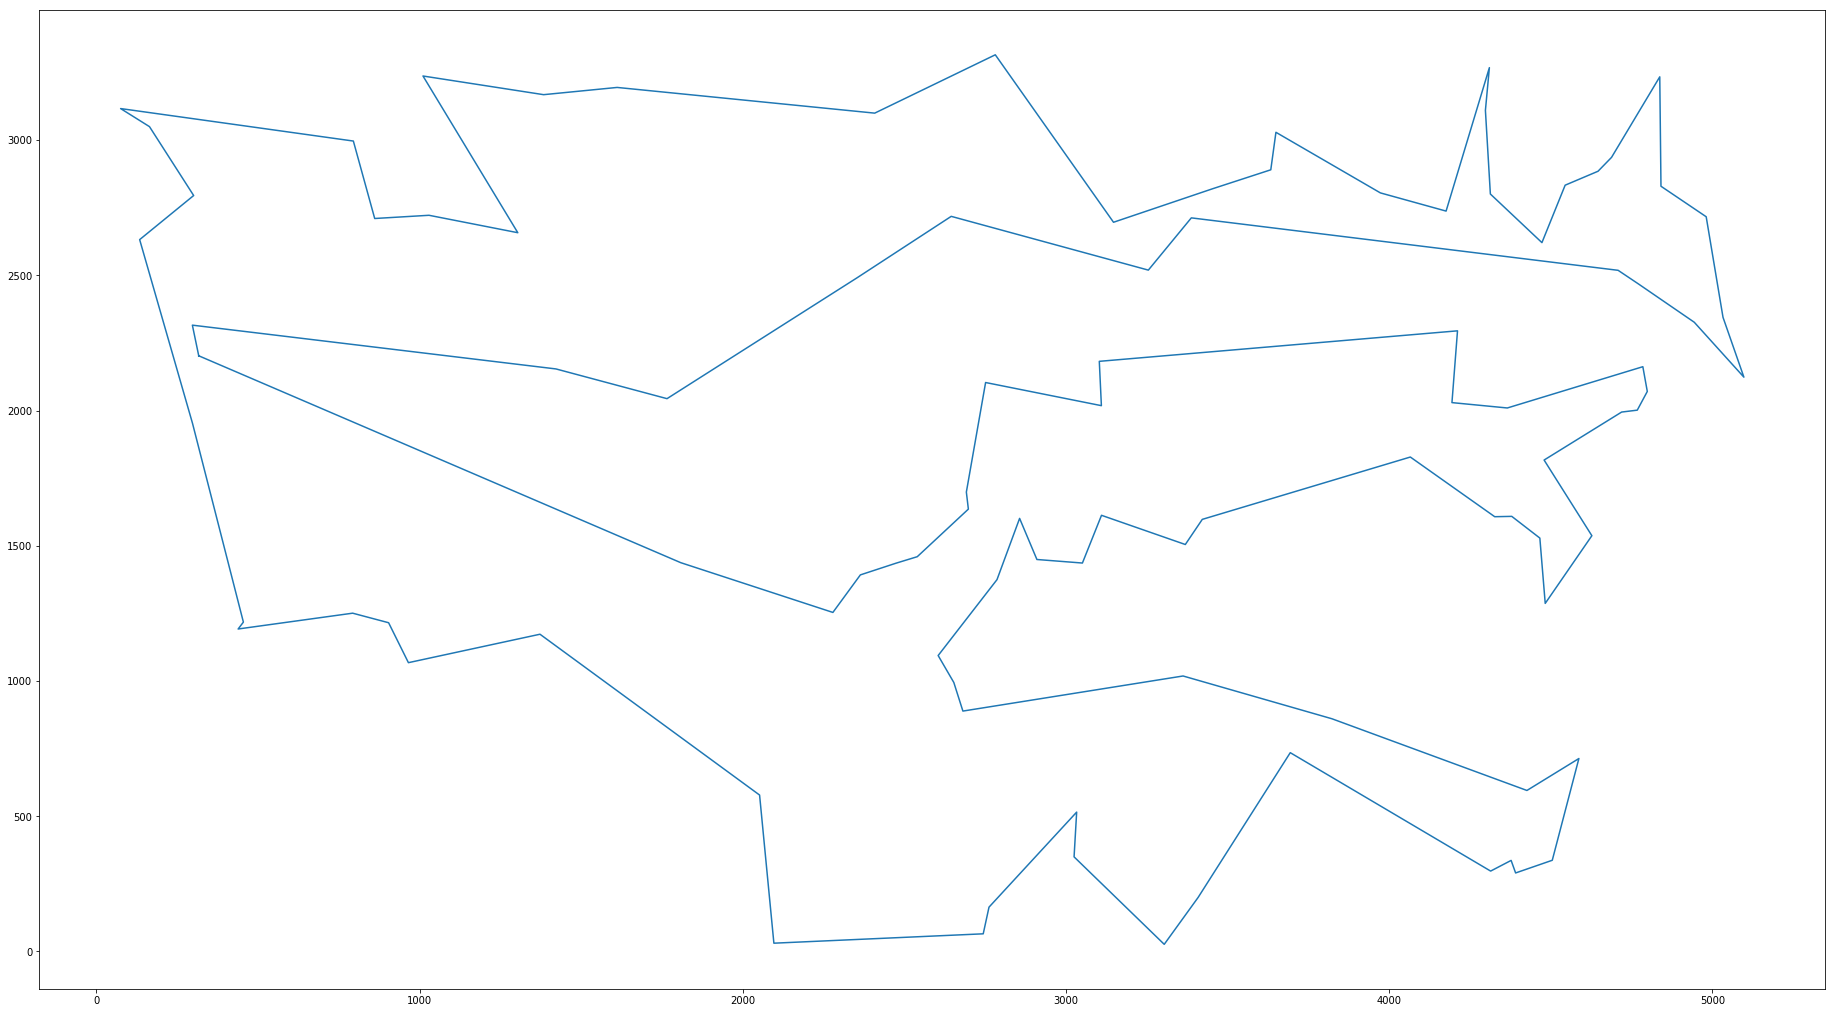

In [62]:
plt.figure(figsize=(32,18))
plt.rcParams['agg.path.chunksize'] = 10000 
plt.plot(cities.X[best_path], cities.Y[best_path])
#plt.show()

In [2]:
from ant_colony  import ant_colony

#given some nodes, and some locations...
test_nodes = {0: (0, 7), 1: (3, 9), 2: (12, 4), 3: (14, 11), 4: (8, 11),
    5: (15, 6), 6: (6, 15), 7: (15, 9), 8: (12, 10), 9: (10, 7)}

#...and a function to get distance between nodes...
def distance(start, end):
    x_distance = abs(start[0] - end[0])
    y_distance = abs(start[1] - end[1])

    #c = sqrt(a^2 + b^2)
    import math
    return math.sqrt(pow(x_distance, 2) + pow(y_distance, 2))

#...we can make a colony of ants...
colony = ant_colony(test_nodes, distance)

#...that will find the optimal solution with ACO
answer = colony.mainloop()

AttributeError: 'dict_keys' object has no attribute 'remove'